In [41]:
transform_pixels = 512

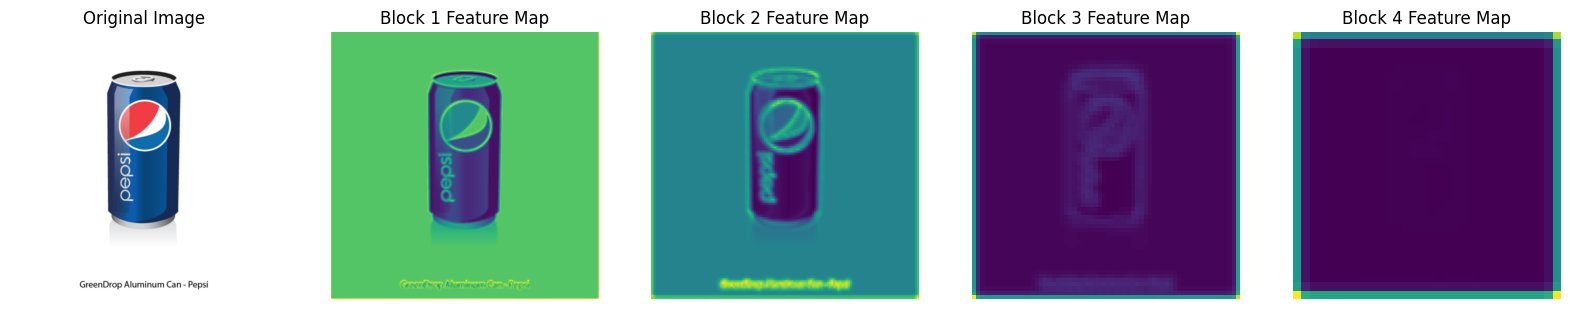

In [29]:
import torch
from torch import nn
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

import plotly.graph_objs as go
from plotly.offline import plot


# Define the model classes
class ConvBlock(nn.Module):
    def __init__(self, num_layers, in_channels, out_channels):
        super().__init__()
        self.convs = nn.ModuleList(
            [nn.Sequential(
                nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, 3, padding=1),
                nn.ReLU()
            ) for i in range(num_layers)]
        )
        self.downsample = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        for conv in self.convs:
            x = conv(x)
        x = self.downsample(x)
        return x

class CNN(nn.Module):
    def __init__(self, in_channels, num_blocks, num_classes):
        super().__init__()
        first_channels = 64
        self.blocks = nn.ModuleList(
            [ConvBlock(
                2 if i == 0 else 3,
                in_channels=(in_channels if i == 0 else first_channels * (2**(i - 1))),
                out_channels=first_channels * (2**i))
             for i in range(num_blocks)]
        )
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.cls = nn.Linear(first_channels * (2**(num_blocks - 1)), num_classes)

    def forward(self, x, return_features=False):
        features = []
        for block in self.blocks:
            x = block(x)
            features.append(x)
        x = self.global_pool(x)
        x = x.flatten(1)
        logits = self.cls(x)
        if return_features:
            return logits, features
        return logits

# Load and preprocess the image
def load_image(image_path, transform):
    image = Image.open(image_path).convert('RGB')
    image = transform(image)
    return image.unsqueeze(0)



# Define the image transformation
transform = transforms.Compose([
    transforms.Resize((transform_pixels, transform_pixels)),
    transforms.ToTensor()
])

# Initialize the model
model = CNN(3, 4, 10)

# Load a sample image
image_path = './productImages/pepsi.jpg'
image = load_image(image_path, transform)

# Get the output and features from the model
model.eval()
with torch.no_grad():
    logits, features = model(image, return_features=True)

# Plot the original image and feature maps
def plot_features(image, features):
    fig, axs = plt.subplots(1, len(features) + 1, figsize=(20, 5))
    axs[0].imshow(image.permute(1, 2, 0).numpy())
    axs[0].set_title('Original Image')
    axs[0].axis('off')

    for i, feature in enumerate(features):
        feature_map = feature.squeeze().mean(dim=0).cpu().numpy()
        axs[i + 1].imshow(feature_map, cmap='viridis')
        axs[i + 1].set_title(f'Block {i + 1} Feature Map')
        axs[i + 1].axis('off')

    plt.show()

# Plot the features
plot_features(image.squeeze(), features)


## Extract points

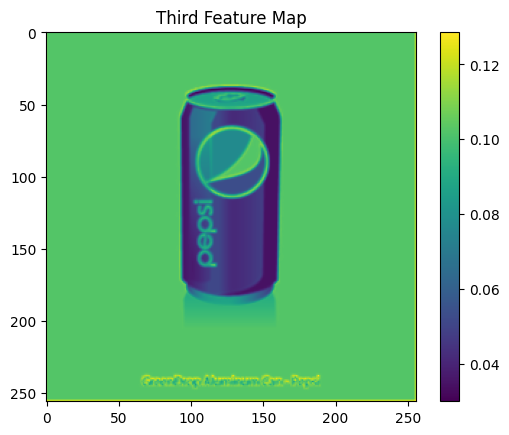

In [30]:
import numpy as np
import plotly.graph_objs as go
from plotly.offline import plot
import matplotlib.pyplot as plt

# Function to extract non-zero points from the third feature map and include color information
def extract_points(feature, max_points=1000):
    # Thresholding to find significant activations
    threshold = feature.mean().item()
    feature = feature.squeeze().cpu().numpy()
    nonzero_points = np.argwhere(feature > threshold)

    if len(nonzero_points) > max_points:
        indices = np.random.choice(len(nonzero_points), max_points, replace=False)
        nonzero_points = nonzero_points[indices]
    
    points = [(point[1], point[2], feature[point[0], point[1], point[2]]) for point in nonzero_points]  # (x, y, color)
    return points

# Function to plot points in 3D
def plot_3d(points):
    if not points:
        print("No significant points found.")
        return

    x_coords, y_coords, colors = zip(*points)
    z_coords = np.zeros(len(x_coords))  # Set Z-coordinates to 0

    # Create scatter3d trace
    trace = go.Scatter3d(
        x=x_coords,
        y=y_coords,
        z=z_coords,
        mode='markers',
        marker=dict(
            size=2,
            color=colors,  # Color based on extracted color information
            colorscale='Viridis',
            opacity=1
        ),
        name='Image'
    )

    # Create layout
    layout = go.Layout(
        scene=dict(
            xaxis=dict(title='X'),
            yaxis=dict(title='Y'),
            zaxis=dict(title='Z')
        ),
        title='Filtered Image in 3D Space'
    )

    # Create figure
    fig = go.Figure(data=[trace], layout=layout)

    # Plot and show as a popup
    plot(fig, auto_open=True)

# Function to plot the third feature map as an image
def plot_feature_map(feature):
    feature_map = feature.squeeze().cpu().numpy()
    mean_feature_map = feature_map.mean(axis=0)  # Average across channels

    plt.imshow(mean_feature_map, cmap='viridis')
    plt.colorbar()
    plt.title('Third Feature Map')
    plt.show()

# Example usage (assuming features is already obtained from the model):
# Only use the third feature map
third_feature = features[0]
points = extract_points(third_feature, max_points=100000)

# Plot the feature map as an image
plot_feature_map(third_feature)

# Plot the points in 3D
plot_3d(points)


In [31]:
import matplotlib.pyplot as plt

def save_feature_map(feature, save_path):
    feature_map = feature.squeeze().cpu().numpy()
    mean_feature_map = feature_map.mean(axis=0)  # Average across channels

    plt.imshow(mean_feature_map, cmap='viridis')
    # plt.colorbar()
    plt.axis('off')  # Turn off the axis
    plt.savefig(save_path, format='png', bbox_inches='tight', pad_inches=0)
    plt.close()
    print(f"Feature map saved as {save_path}")

# Example usage (assuming features is already obtained from the model):
third_feature = features[0]  # Use the third feature map
save_path = './example1.png'
save_feature_map(third_feature, save_path)

Feature map saved as ./example1.png


In [4]:
# feature_map[0][4].shape

In [33]:
import numpy as np
from PIL import Image
import plotly.graph_objs as go
from plotly.offline import plot

# Load the image
image_path = './example1.png'
image = Image.open(image_path)

# Ensure the image is in RGB mode
if image.mode != 'RGB':
    image = image.convert('RGB')

# Define the desired width and height for the resized image
# desired_width = 256
# desired_height = 256

# Resize the image
resized_image = image.resize((transform_pixels, transform_pixels))

# Convert the resized image to a numpy array
resized_image_array = np.array(resized_image)

# Print the shape of the resized image array to confirm its dimensions
print("Shape of resized image array:", resized_image_array.shape)

# Ensure the resized image array has the correct shape
if resized_image_array.shape != (transform_pixels, transform_pixels, 3):
    raise ValueError(f"Unexpected shape of resized_image_array: {resized_image_array.shape}")

# Define X, Y, Z coordinates
x_coords = np.tile(np.arange(transform_pixels), transform_pixels)
y_coords = np.repeat(np.arange(transform_pixels), transform_pixels)

# Calculate intensity based on RGB values
intensity = np.sum(resized_image_array, axis=2) / 3  # Average RGB values to get intensity

# Define intensity thresholds
thresholds = [50, 100, 150, 200]  # Adjust these thresholds as needed

# Map intensity to discrete values based on thresholds
z_coords = np.digitize(intensity, thresholds, right=True)

# Extract RGB values
reshaped_image_array = resized_image_array.reshape(-1, 3)
colors = ['rgb({}, {}, {})'.format(int(r), int(g), int(b)) for r, g, b in reshaped_image_array]

total_pixel = transform_pixels * transform_pixels  # Total number of pixels

fig = go.Figure(data=[go.Scatter3d(
    x=x_coords[:total_pixel],
    y=y_coords[:total_pixel],
    z=z_coords.ravel()[:total_pixel],  # Flatten and take subset
    mode='markers',
    marker=dict(
        size=2,
        color=colors[:total_pixel],  # set color to an array/list of desired values
        opacity=1
    )
)])

# Tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

# Plot and show as a popup
plot(fig, auto_open=True)


Shape of resized image array: (512, 512, 3)


'temp-plot.html'

### Set max threshold

In [34]:
# Define the maximum threshold value
max_threshold = 100  # Adjust this value as needed

# Filter the pixels based on the intensity threshold
filtered_indices = intensity.ravel() < max_threshold

# Apply the filter to the coordinates and colors
filtered_x_coords = x_coords[filtered_indices]
filtered_y_coords = y_coords[filtered_indices]
filtered_z_coords = z_coords.ravel()[filtered_indices]
filtered_colors = np.array(colors)[filtered_indices]

fig = go.Figure(data=[go.Scatter3d(
    x=filtered_x_coords,
    y=filtered_y_coords,
    z=filtered_z_coords,
    mode='markers',
    marker=dict(
        size=2,
        color=filtered_colors,  # set color to an array/list of desired values
        opacity=1
    )
)])

# Tight layout
# Tight layout
fig.update_layout(
    scene=dict(
        xaxis=dict(nticks=10, range=[0, transform_pixels],),
        yaxis=dict(nticks=10, range=[0, transform_pixels],),
        zaxis=dict(nticks=10, range=[0, len(thresholds)]),
    ),
    margin=dict(l=0, r=0, b=0, t=0)
)

# Plot and show as a popup
plot(fig, auto_open=True)

'temp-plot.html'

### Save above feature as a image

In [47]:
# Now process the new image with 512 x 512 size
new_image_path = './productImages/pepsi.jpg'
new_image_transform = transforms.Compose([
    transforms.Resize((transform_pixels, transform_pixels)),
    transforms.ToTensor()
])

new_image = load_image(new_image_path, new_image_transform)
new_image_array = new_image.squeeze(0).permute(1, 2, 0).numpy() * 255
new_image_array = new_image_array.astype(np.uint8)

# Apply the same intensity thresholding and filtering logic to crop the new image
new_intensity = np.sum(new_image_array, axis=2) / 3  # Average RGB values to get intensity
new_filtered_indices = new_intensity.ravel() < 255

# Apply the filter to the new image's coordinates and colors
new_filtered_x_coords = x_coords[new_filtered_indices]
new_filtered_y_coords = y_coords[new_filtered_indices]
new_filtered_z_coords = z_coords.ravel()[new_filtered_indices]
new_filtered_colors = ['rgb({}, {}, {})'.format(int(r), int(g), int(b)) for r, g, b in new_image_array.reshape(-1, 3)[new_filtered_indices]]

new_fig = go.Figure(data=[go.Scatter3d(
    x=new_filtered_x_coords,
    y=new_filtered_y_coords,
    z=new_filtered_z_coords,
    mode='markers',
    marker=dict(
        size=2,
        color=new_filtered_colors,  # set color to an array/list of desired values
        opacity=1
    )
)])

# Tight layout
new_fig.update_layout(
    scene=dict(
        xaxis=dict(nticks=10, range=[0, transform_pixels],),
        yaxis=dict(nticks=10, range=[0, transform_pixels],),
        zaxis=dict(nticks=10, range=[0, len(thresholds)]),
    ),
    margin=dict(l=0, r=0, b=0, t=0)
)

# Plot and show as a popup
plot(new_fig, auto_open=True)

#! Todo : 
* Show the extracted feature
* revert back to original image colors as points
* image perspective / orientation estimation using AI
* Attach multiple perspectives

* Create transformers to create a memory like feature
* Continious research and development setup
